In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from keras.layers import Input, Embedding, Dense, Flatten, Dropout, SpatialDropout1D, Activation, concatenate, BatchNormalization
from keras.optimizers import Adam, SGD
from keras.layers.activation import ReLU, PReLU, LeakyReLU, ELU
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('../data/kmrd/kmr_dataset/datafile/kmrd-small/rates.csv')
train_df, val_df = train_test_split(df, test_size=0.2, random_state=1234, shuffle=True)

In [3]:
movies_df = pd.read_csv('../data/kmrd/kmr_dataset/datafile/kmrd-small/movies.txt', sep='\t', encoding='utf-8')
movies_df = movies_df.set_index('movie')

castings_df = pd.read_csv('../data/kmrd/kmr_dataset/datafile/kmrd-small/castings.csv', encoding='utf-8')
countries_df = pd.read_csv('../data/kmrd/kmr_dataset/datafile/kmrd-small/countries.csv', encoding='utf-8')
genres_df = pd.read_csv('../data/kmrd/kmr_dataset/datafile/kmrd-small/genres.csv', encoding='utf-8')

# Get genre information
genres = [(list(set(x['movie'].values))[0], '/'.join(x['genre'].values)) for index, x in genres_df.groupby('movie')]
combined_genres_df = pd.DataFrame(data=genres, columns=['movie', 'genres'])
combined_genres_df = combined_genres_df.set_index('movie')

# Get castings information
castings = [(list(set(x['movie'].values))[0], x['people'].values) for index, x in castings_df.groupby('movie')]
combined_castings_df = pd.DataFrame(data=castings, columns=['movie','people'])
combined_castings_df = combined_castings_df.set_index('movie')

# Get countries for movie information
countries = [(list(set(x['movie'].values))[0], '/'.join(x['country'].values)) for index, x in countries_df.groupby('movie')]
combined_countries_df = pd.DataFrame(data=countries, columns=['movie', 'country'])
combined_countries_df = combined_countries_df.set_index('movie')

movies_df = pd.concat([movies_df, combined_genres_df, combined_castings_df, combined_countries_df], axis=1)
movies_df
# print(movies_df.shape)
# print(movies_df.head())

,title,title_eng,year,grade,genres,people,country
movie,,,,,,,
10001,시네마 천국,"Cinema Paradiso , 1988",2013.0,전체 관람가,드라마/멜로/로맨스,"[4374, 178, 3241, 47952, 47953, 19538, 18991, ...",이탈리아/프랑스
10002,빽 투 더 퓨쳐,"Back To The Future , 1985",2015.0,12세 관람가,SF/코미디,"[1076, 4603, 917, 8637, 5104, 9986, 7470, 9987]",미국
10003,빽 투 더 퓨쳐 2,"Back To The Future Part 2 , 1989",2015.0,12세 관람가,SF/코미디,"[1076, 4603, 917, 5104, 391, 5106, 5105, 5107,...",미국
10004,빽 투 더 퓨쳐 3,"Back To The Future Part III , 1990",1990.0,전체 관람가,서부/SF/판타지/코미디,"[1076, 4603, 1031, 5104, 10001, 5984, 10002, 1...",미국
10005,스타워즈 에피소드 4 - 새로운 희망,"Star Wars , 1977",1997.0,PG,판타지/모험/SF/액션,"[1007, 535, 215, 1236, 35]",미국
...,...,...,...,...,...,...,...
10995,공포의 여정,"Journey Into Fear , 1975",NaN,PG,스릴러,"[2464, 16573, 2101, 10619, 17815, 17814, 16848...",미국
10996,버스틴 루즈,"Bustin' Loose , 1981",NaN,R,코미디,"[9598, 6520, 506, 11123]",미국
10997,블랙 엔젤,"Mausoleum , 1983",NaN,청소년 관람불가,공포,"[198255, 17831, 10233, 140473, 31534, 200668, ...",미국


In [4]:
movies_df.isna().sum()

title          7
title_eng      8
year         390
grade         42
genres        35
people        11
country        9
dtype: int64

In [5]:
movies_df.dropna(inplace=True)
movies_df

,title,title_eng,year,grade,genres,people,country
movie,,,,,,,
10001,시네마 천국,"Cinema Paradiso , 1988",2013.0,전체 관람가,드라마/멜로/로맨스,"[4374, 178, 3241, 47952, 47953, 19538, 18991, ...",이탈리아/프랑스
10002,빽 투 더 퓨쳐,"Back To The Future , 1985",2015.0,12세 관람가,SF/코미디,"[1076, 4603, 917, 8637, 5104, 9986, 7470, 9987]",미국
10003,빽 투 더 퓨쳐 2,"Back To The Future Part 2 , 1989",2015.0,12세 관람가,SF/코미디,"[1076, 4603, 917, 5104, 391, 5106, 5105, 5107,...",미국
10004,빽 투 더 퓨쳐 3,"Back To The Future Part III , 1990",1990.0,전체 관람가,서부/SF/판타지/코미디,"[1076, 4603, 1031, 5104, 10001, 5984, 10002, 1...",미국
10005,스타워즈 에피소드 4 - 새로운 희망,"Star Wars , 1977",1997.0,PG,판타지/모험/SF/액션,"[1007, 535, 215, 1236, 35]",미국
...,...,...,...,...,...,...,...
10983,사랑이 머무는 곳에,"Ice Castles , 1978",1979.0,PG,멜로/로맨스/드라마,"[963, 11564, 4739, 17739, 13072]",미국
10985,할리와 말보로 맨,"Harley Davidson And The Marlboro Man , 1991",1991.0,청소년 관람불가,액션,"[1098, 4337, 2950, 3272, 6166, 1586]",미국
10988,파리의 여인,"A Woman Of Paris , 1923",2015.0,NR,드라마,"[17767, 17766, 17765, 17764, 17763, 14327, 177...",미국


In [6]:
valid_movie_ids = list(movies_df.index)
len(valid_movie_ids)

583

In [7]:
train_df.shape

(112568, 4)

In [8]:
train_df = train_df[np.isin(train_df['movie'], valid_movie_ids)]
val_df = val_df[np.isin(val_df['movie'], valid_movie_ids)]

print(train_df.shape, val_df.shape)

(111186, 4) (27774, 4)


In [9]:
train_df['genres'] = train_df.apply(lambda x: movies_df.loc[x['movie']]['genres'], axis=1)
val_df['genres'] = val_df.apply(lambda x: movies_df.loc[x['movie']]['genres'], axis=1)

train_df['country'] = train_df.apply(lambda x: movies_df.loc[x['movie']]['country'], axis=1)
val_df['country'] = val_df.apply(lambda x: movies_df.loc[x['movie']]['country'], axis=1)

train_df['grade'] = train_df.apply(lambda x: movies_df.loc[x['movie']]['grade'], axis=1)
val_df['grade'] = val_df.apply(lambda x: movies_df.loc[x['movie']]['grade'], axis=1)

train_df['year'] = train_df.apply(lambda x: movies_df.loc[x['movie']]['year'], axis=1)
val_df['year'] = val_df.apply(lambda x: movies_df.loc[x['movie']]['year'], axis=1)

In [10]:
train_df.head()

,user,movie,rate,time,genres,country,grade,year
137023,48423,10764,10,1212241560,멜로/로맨스/드라마,한국,12세 관람가,1987.0
92868,17307,10170,10,1122185220,액션,영국,PG,1985.0
94390,18180,10048,10,1573403460,드라마,미국,12세 관람가,2016.0
22289,1498,10001,9,1432684500,드라마/멜로/로맨스,이탈리아/프랑스,전체 관람가,2013.0
80155,12541,10022,10,1370458140,드라마/액션,미국,12세 관람가,1980.0


In [11]:
val_df.head()

,user,movie,rate,time,genres,country,grade,year
76196,11242,10253,10,1437788760,액션/스릴러/범죄,미국/영국,15세 관람가,1990.0
109800,26903,10102,10,1322643900,멜로/로맨스/뮤지컬/드라마,미국,전체 관람가,2017.0
60479,7101,10007,1,1314804000,판타지/SF/액션/모험,미국,PG,1997.0
71460,9705,10016,10,1228825200,코미디/가족/모험/범죄,미국,전체 관람가,1991.0
73864,10616,10106,8,1425046200,멜로/로맨스/드라마,미국,12세 관람가,1999.0


In [12]:
train_target = train_df.apply(lambda x: 1 if x['rate'] > 8 else 0, axis=1)
val_target = val_df.apply(lambda x: 1 if x['rate'] > 8 else 0, axis=1)

In [13]:
from typing import List, Tuple

import numpy as np
import pandas as pd


class WidePreprocessor():
    def __init__(self, wide_cols: List[str], crossed_cols: List[Tuple[str, str]] = None):
        self.wide_cols = wide_cols
        self.crossed_cols = crossed_cols

    def fit(self, df: pd.DataFrame) -> "WidePreprocessor":
        df_wide = self._prepare_wide(df)
        self.wide_crossed_cols = df_wide.columns.tolist()
        glob_feature_list = self._make_global_feature_list(
            df_wide[self.wide_crossed_cols]
        )
        # leave 0 for padding/"unseen" categories
        self.encoding_dict = {v: i + 1 for i, v in enumerate(glob_feature_list)}
        self.wide_dim = len(self.encoding_dict)
        self.inverse_encoding_dict = {k: v for v, k in self.encoding_dict.items()}
        self.inverse_encoding_dict[0] = "unseen"
        return self

    def transform(self, df: pd.DataFrame) -> np.ndarray:
        df_wide = self._prepare_wide(df)
        encoded = np.zeros([len(df_wide), len(self.wide_crossed_cols)])
        for col_i, col in enumerate(self.wide_crossed_cols):
            encoded[:, col_i] = df_wide[col].apply(
                lambda x: self.encoding_dict[col + "_" + str(x)]
                if col + "_" + str(x) in self.encoding_dict
                else 0
            )
        return encoded.astype("int64")

    def inverse_transform(self, encoded: np.ndarray) -> pd.DataFrame:
        decoded = pd.DataFrame(encoded, columns=self.wide_crossed_cols)
        decoded = decoded.applymap(lambda x: self.inverse_encoding_dict[x])
        for col in decoded.columns:
            rm_str = "".join([col, "_"])
            decoded[col] = decoded[col].apply(lambda x: x.replace(rm_str, ""))
        return decoded

    def fit_transform(self, df: pd.DataFrame) -> np.ndarray:
        return self.fit(df).transform(df)

    def _make_global_feature_list(self, df: pd.DataFrame) -> List:
        glob_feature_list = []
        for column in df.columns:
            glob_feature_list += self._make_column_feature_list(df[column])
        return glob_feature_list

    def _make_column_feature_list(self, s: pd.Series) -> List:
        return [s.name + "_" + str(x) for x in s.unique()]

    def _cross_cols(self, df: pd.DataFrame):
        df_cc = df.copy()
        crossed_colnames = []
        for cols in self.crossed_cols:
            for c in cols:
                df_cc[c] = df_cc[c].astype("str")
            colname = "_".join(cols)
            df_cc[colname] = df_cc[list(cols)].apply(lambda x: "-".join(x), axis=1)
            crossed_colnames.append(colname)
        return df_cc[crossed_colnames]

    def _prepare_wide(self, df: pd.DataFrame):
        if self.crossed_cols is not None:
            df_cc = self._cross_cols(df)
            return pd.concat([df[self.wide_cols], df_cc], axis=1)
        else:
            return df.copy()[self.wide_cols]


In [14]:
class DeepPreprocessor():
    def __init__(self, categorical_cols: List[str], continuous_cols: List[str]=None):
        self.categorical_cols = categorical_cols
        self.continuous_cols = continuous_cols
        
    def fit_transform(self, df: pd.DataFrame):
        copy_df = df.copy()
        
        for c in self.categorical_cols:
            le = LabelEncoder()
            copy_df[c] = le.fit_transform(copy_df[c])
              
        X_train_category = np.array(copy_df[self.categorical_cols])

        scaler = StandardScaler()
        X_train_continue = scaler.fit_transform(np.array(copy_df[self.continuous_cols]))
        
        return X_train_category, X_train_continue

In [15]:
class Wide:
    def __init__(self):
        self.wide_model = None
    
    def make_wide_model(self, X_wide: np.array) -> "WideModel":
        input_wide = Input(shape=(X_wide.shape[1],))
        emb_wide = Embedding(len(np.unique(X_wide))+1, 1, input_length=X_wide.shape[1])(input_wide)
        wide_model = Flatten()(emb_wide)
        
        self.wide_model = wide_model
        return self

In [16]:
class Deep:
    def __init__(self, categorical_cols: List[str], continuous_cols: List[str]=None, embed_dim_ratio: float=0.5):
        self.category_inputs = []
        self.continue_inputs = []
        self.categorical_cols = categorical_cols
        self.continuous_cols = continuous_cols
        self.deep_model = None
        self.embed_dim_ratio= embed_dim_ratio
        
    def make_deep_model(self, df: pd.DataFrame):
        copy_df = df.copy()
        category_embeds = []
        
        for i in range(len(self.categorical_cols)):
            input_i = Input(shape=(1,), dtype='int32')
            dim = len(np.unique(copy_df[self.categorical_cols[i]]))
            embed_dim = int(np.ceil(dim**self.embed_dim_ratio))
            embed_i = Embedding(dim, embed_dim, input_length=1)(input_i)
            flatten_i = Flatten()(embed_i)
            self.category_inputs.append(input_i)
            category_embeds.append(flatten_i)

        self.continue_inputs = Input(shape=(len(self.continuous_cols),))
        continue_dense = Dense(128, use_bias=False)(self.continue_inputs)

        concat_embeds = concatenate([continue_dense] + category_embeds)
        concat_embeds = Activation('relu')(concat_embeds)
        bn_concat = BatchNormalization()(concat_embeds)

        fc1 = Dense(512, use_bias=False)(bn_concat)
        relu1 = ReLU()(fc1)
        bn1 = BatchNormalization()(relu1)
        fc2 = Dense(256, use_bias=False)(bn1)
        relu2 = ReLU()(fc2)
        bn2 = BatchNormalization()(relu2)
        fc3 = Dense(128)(bn2)
        relu3 = ReLU()(fc3)
        
        self.deep_model = relu3
        
        return self

In [17]:
class WideDeep:
    def __init__(self, wide: Wide, deep: Deep, activation_func: str = "sigmoid"):
        self.wide_instance = wide 
        self.deep_instance = deep
        self.activation_func = activation_func
        
    def make_wide_deep_model(self):
        out_layer = concatenate([self.deep_instance.deep_model, self.wide_instance.wide_model])
        inputs = [self.deep_instance.continue_inputs] + self.deep_instance.category_inputs + [self.wide_instance.wide_model]
        output = Dense(1, activation=self.activation_func)(out_layer)
        model = Model(inputs=inputs, outputs=output)
        
        return model

In [18]:
wide_cols = [
    "genres", 
    "country",
    "grade"
]

crossed_cols = [
    ("genres","country"),
    ("country","grade"),
    ("genres", "grade")
]

In [19]:
wide_preprocessor = WidePreprocessor(wide_cols=wide_cols, crossed_cols=crossed_cols)
X_wide = wide_preprocessor.fit_transform(train_df)

In [20]:
wide_preprocessor.encoding_dict

{'genres_멜로/로맨스/드라마': 1,
 'genres_액션': 2,
 'genres_드라마': 3,
 'genres_드라마/멜로/로맨스': 4,
 'genres_드라마/액션': 5,
 'genres_스릴러/범죄/공포': 6,
 'genres_멜로/로맨스/뮤지컬/드라마': 7,
 'genres_SF/액션/스릴러/공포': 8,
 'genres_가족/모험/코미디': 9,
 'genres_드라마/액션/범죄': 10,
 'genres_판타지/스릴러/공포/미스터리': 11,
 'genres_느와르/액션': 12,
 'genres_멜로/로맨스/코미디': 13,
 'genres_드라마/서사': 14,
 'genres_코미디/가족/모험/범죄': 15,
 'genres_드라마/코미디': 16,
 'genres_액션/모험': 17,
 'genres_SF/액션/스릴러': 18,
 'genres_SF/코미디': 19,
 'genres_드라마/전쟁': 20,
 'genres_액션/범죄': 21,
 'genres_멜로/로맨스/드라마/전쟁': 22,
 'genres_드라마/스릴러/공포': 23,
 'genres_드라마/액션/코미디': 24,
 'genres_드라마/범죄': 25,
 'genres_멜로/로맨스/뮤지컬/코미디': 26,
 'genres_판타지/액션/모험': 27,
 'genres_SF/액션/드라마': 28,
 'genres_공포': 29,
 'genres_드라마/코미디/범죄': 30,
 'genres_애니메이션/액션/코미디/SF/가족': 31,
 'genres_판타지/액션/코미디/공포': 32,
 'genres_판타지/SF/액션/모험': 33,
 'genres_액션/코미디': 34,
 'genres_판타지/SF/모험/가족': 35,
 'genres_드라마/느와르/액션/범죄': 36,
 'genres_드라마/액션/모험': 37,
 'genres_판타지/멜로/로맨스': 38,
 'genres_멜로/로맨스/드라마/코미디': 39,
 'genres_코미디': 40,
 'gen

In [21]:
wide_preprocessor.inverse_transform(X_wide)

,genres,country,grade,genres_country,country_grade,genres_grade
0,멜로/로맨스/드라마,한국,12세 관람가,멜로/로맨스/드라마-한국,한국-12세 관람가,멜로/로맨스/드라마-12세 관람가
1,액션,영국,PG,액션-영국,영국-PG,액션-PG
2,드라마,미국,12세 관람가,드라마-미국,미국-12세 관람가,드라마-12세 관람가
3,드라마/멜로/로맨스,이탈리아/프랑스,전체 관람가,드라마/멜로/로맨스-이탈리아/프랑스,이탈리아/프랑스-전체 관람가,드라마/멜로/로맨스-전체 관람가
4,드라마/액션,미국,12세 관람가,드라마/액션-미국,미국-12세 관람가,드라마/액션-12세 관람가
...,...,...,...,...,...,...
111181,멜로/로맨스/뮤지컬/코미디,미국,전체 관람가,멜로/로맨스/뮤지컬/코미디-미국,미국-전체 관람가,멜로/로맨스/뮤지컬/코미디-전체 관람가
111182,액션/모험/코미디,홍콩,전체 관람가,액션/모험/코미디-홍콩,홍콩-전체 관람가,액션/모험/코미디-전체 관람가
111183,SF/코미디,미국,12세 관람가,SF/코미디-미국,미국-12세 관람가,SF/코미디-12세 관람가
111184,SF/공포,미국,15세 관람가,SF/공포-미국,미국-15세 관람가,SF/공포-15세 관람가


In [22]:
X_wide

array([[  1, 179, 228, 237, 526, 624],
       [  2, 180, 229, 238, 527, 625],
       [  3, 181, 228, 239, 528, 626],
       ...,
       [ 19, 181, 228, 257, 528, 645],
       [ 57, 181, 232, 309, 532, 700],
       [ 18, 187, 232, 256, 539, 644]])

In [23]:
categorical_cols = [
    "genres",
    "country",
    "grade"
]

continuous_cols = [
    "year"
]

In [24]:
deep_preprocessor = DeepPreprocessor(categorical_cols, continuous_cols)
X_train_category, X_train_continue = deep_preprocessor.fit_transform(train_df)

In [25]:
wide = Wide().make_wide_model(X_wide)

Metal device set to: Apple M1 Pro


In [26]:
deep = Deep(categorical_cols, continuous_cols).make_deep_model(train_df)

In [27]:
model = WideDeep(wide, deep).make_wide_deep_model()

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                              

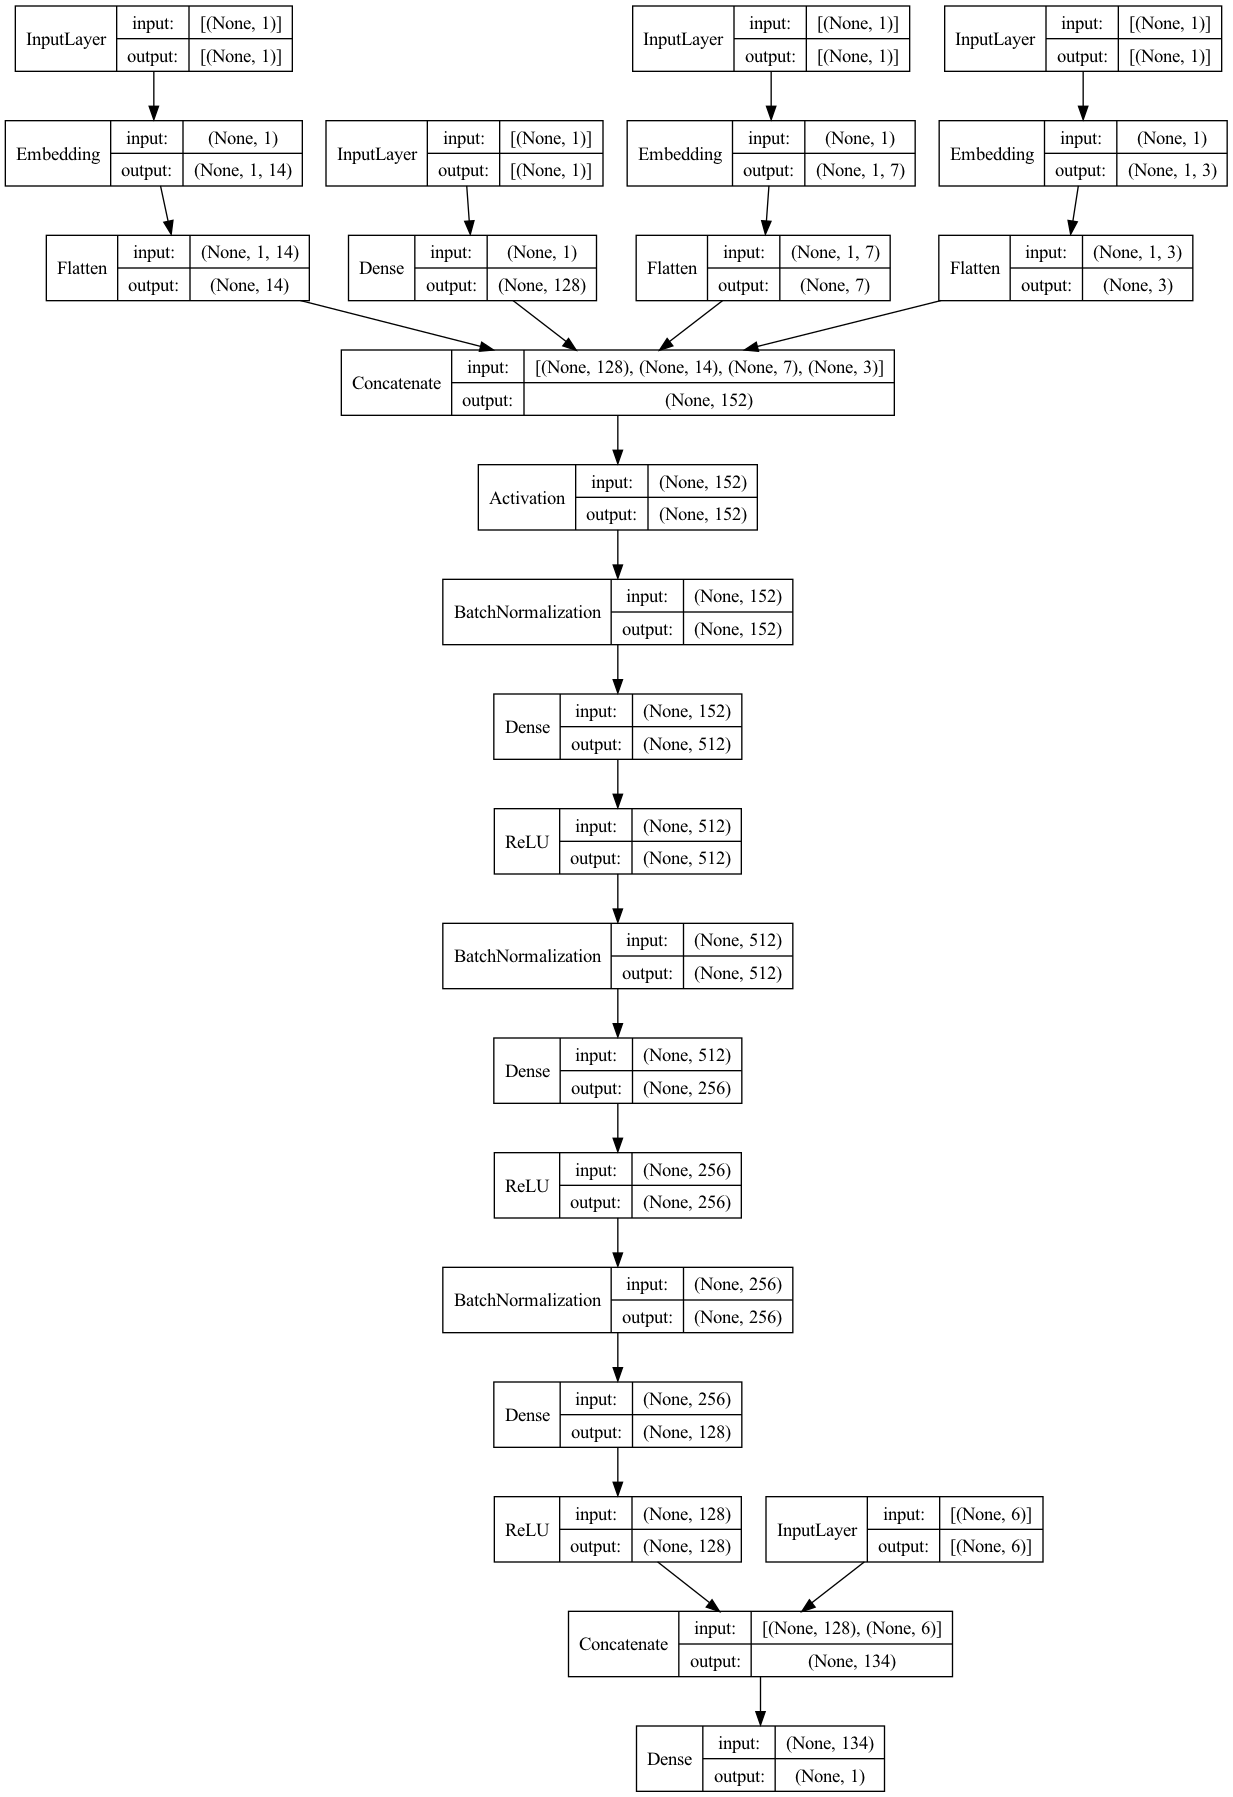

In [29]:
plot_model(model, to_file='keras_deep_wide_model.png', show_shapes=True, show_layer_names=False)

In [30]:
checkpoint = ModelCheckpoint(filepath='./checkpoint/wide-deep-keras.h5', monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [31]:
input_data = [X_train_continue] + [X_train_category[:, i] for i in range(X_train_category.shape[1])] + [X_wide]

In [32]:
epochs = 30
optimizer ='adam'
batch_size = 128

In [33]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(input_data, train_target, epochs=epochs, batch_size=batch_size, validation_split=0.15, callbacks=[checkpoint, early_stopping])

Epoch 1/30


2023-07-19 16:58:58.562358: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


739/739 [==============================] - ETA: 0s - loss: 1.7582 - accuracy: 0.7198
Epoch 1: val_loss improved from inf to 0.73185, saving model to ./checkpoint/wide-deep-keras.h5
739/739 [==============================] - 21s 27ms/step - loss: 1.7582 - accuracy: 0.7198 - val_loss: 0.7319 - val_accuracy: 0.7734
Epoch 2/30
739/739 [==============================] - ETA: 0s - loss: 0.6615 - accuracy: 0.7490
Epoch 2: val_loss improved from 0.73185 to 0.59563, saving model to ./checkpoint/wide-deep-keras.h5
739/739 [==============================] - 18s 25ms/step - loss: 0.6615 - accuracy: 0.7490 - val_loss: 0.5956 - val_accuracy: 0.7743
Epoch 3/30
739/739 [==============================] - ETA: 0s - loss: 0.6020 - accuracy: 0.7575
Epoch 3: val_loss improved from 0.59563 to 0.55949, saving model to ./checkpoint/wide-deep-keras.h5
739/739 [==============================] - 18s 25ms/step - loss: 0.6020 - accuracy: 0.7575 - val_loss: 0.5595 - val_accuracy: 0.7773
Epoch 4/30
739/739 [========

In [34]:
wide_preprocessor = WidePreprocessor(wide_cols=wide_cols, crossed_cols=crossed_cols)
X_test_wide = wide_preprocessor.fit_transform(val_df)

In [35]:
deep_preprocessor = DeepPreprocessor(categorical_cols, continuous_cols)
X_test_category, X_test_continue = deep_preprocessor.fit_transform(val_df)

In [39]:
eval_input_data = [X_test_continue] + [X_test_category[:, i] for i in range(X_test_category.shape[1])] + [X_test_wide]
eval_input_data

[array([[-0.68222682],
        [ 1.015756  ],
        [-0.24200905],
        ...,
        [ 0.38687348],
        [ 0.82709125],
        [ 0.38687348]]),
 array([133,  80, 153, ..., 120, 160, 120]),
 array([11,  7,  7, ..., 47,  7, 47]),
 array([1, 7, 4, ..., 7, 1, 7]),
 array([[  1, 176, 226, 235, 518, 616],
        [  2, 177, 227, 236, 519, 617],
        [  3, 177, 228, 237, 520, 618],
        ...,
        [ 88, 194, 227, 347, 561, 724],
        [ 47, 177, 226, 286, 524, 669],
        [ 88, 194, 227, 347, 561, 724]])]

In [41]:
result = model.predict(eval_input_data)
result

868/868 [==============================] - 5s 6ms/step


array([[0.6037675],
       [0.5604578],
       [0.341614 ],
       ...,
       [0.9966897],
       [0.7496477],
       [0.9966897]], dtype=float32)

In [42]:
val_target

76196     1
109800    1
60479     0
71460     1
73864     0
         ..
64944     1
20618     1
118034    0
69366     1
117770    0
Length: 27774, dtype: int64

In [53]:
df_val = pd.DataFrame([result.reshape(-1), val_target]).transpose()
df_val = df_val.rename(columns={0: 'predict', 1: 'real'})
df_val

,predict,real
0,0.603768,1.0
1,0.560458,1.0
2,0.341614,0.0
3,0.868316,1.0
4,0.527697,0.0
...,...,...
27769,0.466830,1.0
27770,0.909736,1.0
27771,0.996690,0.0
27772,0.749648,1.0


In [55]:
df_val['is_predict_over_half'] = df_val['predict'].apply(lambda x: 1 if x >= 0.5 else 0)
df_val

,predict,real,is_predict_over_half
0,0.603768,1.0,1
1,0.560458,1.0,1
2,0.341614,0.0,0
3,0.868316,1.0,1
4,0.527697,0.0,1
...,...,...,...
27769,0.466830,1.0,0
27770,0.909736,1.0,1
27771,0.996690,0.0,1
27772,0.749648,1.0,1


In [59]:
df_val['is_correct'] = df_val.apply(lambda x: x['real'] == x['is_predict_over_half'], axis=1)
df_val

,predict,real,is_predict_over_half,is_correct
0,0.603768,1.0,1,True
1,0.560458,1.0,1,True
2,0.341614,0.0,0,True
3,0.868316,1.0,1,True
4,0.527697,0.0,1,False
...,...,...,...,...
27769,0.466830,1.0,0,False
27770,0.909736,1.0,1,True
27771,0.996690,0.0,1,False
27772,0.749648,1.0,1,True


In [62]:
df_val['is_correct'].sum() / df_val.shape[0]

0.6616619860301001

In [64]:
loss, acc = model.evaluate(eval_input_data, val_target)

868/868 [==============================] - 8s 9ms/step - loss: 0.7484 - accuracy: 0.6617


In [65]:
print(f'test_loss: {loss} - test_acc: {acc}')

test_loss: 0.7483738660812378 - test_acc: 0.6616619825363159
